In [1]:
import csv
import gzip
import io
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd

# Read mapping of codes to country names

In [2]:
INPUT_NAMES_FILENAME = "/Users/namjoolee/Downloads/networks-science-course/practicum/data/trade-countries.csv.gz"
INPUT_TRADE_1980 = "/Users/namjoolee/Downloads/networks-science-course/practicum/data/trade_1980-flows.csv.gz"
INPUT_TRADE_2013 = "/Users/namjoolee/Downloads/networks-science-course/practicum/data/trade_2013-flows.csv.gz"

# Organisation for Economic Co-operation and Development
OECD = set(["AUS", "AUT", "BEL", "CAN", "CHL", "COL", "CZE", "DNK", "EST", "FIN", "FRA",
        "DEU", "GRC", "HUN", "ISL", "IRL", "ISR", "ITA", "JPN", "KOR", "LVA", "LTU",
        "LUX", "MEX", "NLD", "NOR", "NZL", "POL", "CHE", "ESP", "GBR", "PRT", "SVK",
        "SVN", "SWE", "TUR", "USA"])

# Brazil, Russia, India and China
BRIC = set(["BRA", "RUS", "IND", "CHN"])

# COUNTRIES
COUNTRIES = OECD.union(BRIC)

In [3]:
id2name = dict()

# Open a compressed file for reading in text mode
with gzip.open(INPUT_NAMES_FILENAME, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader: # code, name
        id2name[record['code']] = record['name']

# Read flows data into two graphs

In [4]:
g_old = nx.DiGraph()
g_new = nx.DiGraph()


# Creating old graph
with gzip.open(INPUT_TRADE_1980, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader: # flow, country1, country2, currency, amount
        if record['country1'] and record['country2'] in COUNTRIES:
            if record['flow'] == 'Import':
                u = record['country2']
                v = record['country1']
                w = float(record['amount']) / 1e6 if len(record['amount']) > 0 else 0.0
            elif record['flow'] == 'Export':
                u = record['country1']
                v = record['country2']
                w = float(record['amount']) / 1e6 if len(record['amount']) > 0 else 0.0
            if round(w) > 0:
                g_old.add_edge(u, v, weight=w)
    
# Creating new graph
with gzip.open(INPUT_TRADE_2013, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader: # flow, country1, country2, currency, amount
        if record['country1'] and record['country2'] in COUNTRIES:
            if record['flow'] == 'Import':
                u = record['country2']
                v = record['country1']
                w = float(record['amount']) / 1e6 if len(record['amount']) > 0 else 0.0
            elif record['flow'] == 'Export':
                u = record['country1']
                v = record['country2']
                w = float(record['amount']) / 1e6 if len(record['amount']) > 0 else 0.0
            if round(w) > 0:
                g_new.add_edge(u, v, weight=w)

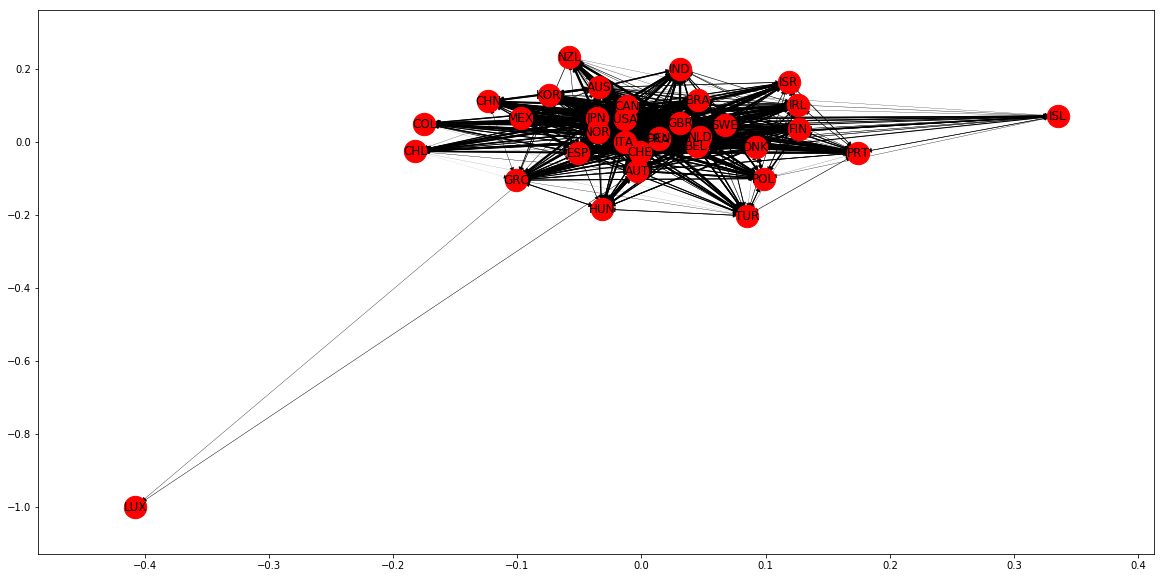

In [5]:
# Draw Old data

EDGE_WIDTH_MULTIPLIER = 0.5
plt.figure(figsize=(20,10))

# Layout the graph using a spring model
pos = nx.spring_layout(g_old, iterations=100, weight="weight")

# Draw the nodes on the screen
nx.draw_networkx_nodes(g_old, pos, node_size=500)

# Add labels to the nodes
nx.draw_networkx_labels(g_old, pos)

# Create an array with edge widths
edgewidth = []
for u, v, d in g_old.edges(data=True):
    weight = math.log(d['weight'])*EDGE_WIDTH_MULTIPLIER
    edgewidth.append(weight)

# Use the edgewidth array to draw the edges
_ = nx.draw_networkx_edges(g_old, pos, width=edgewidth, )


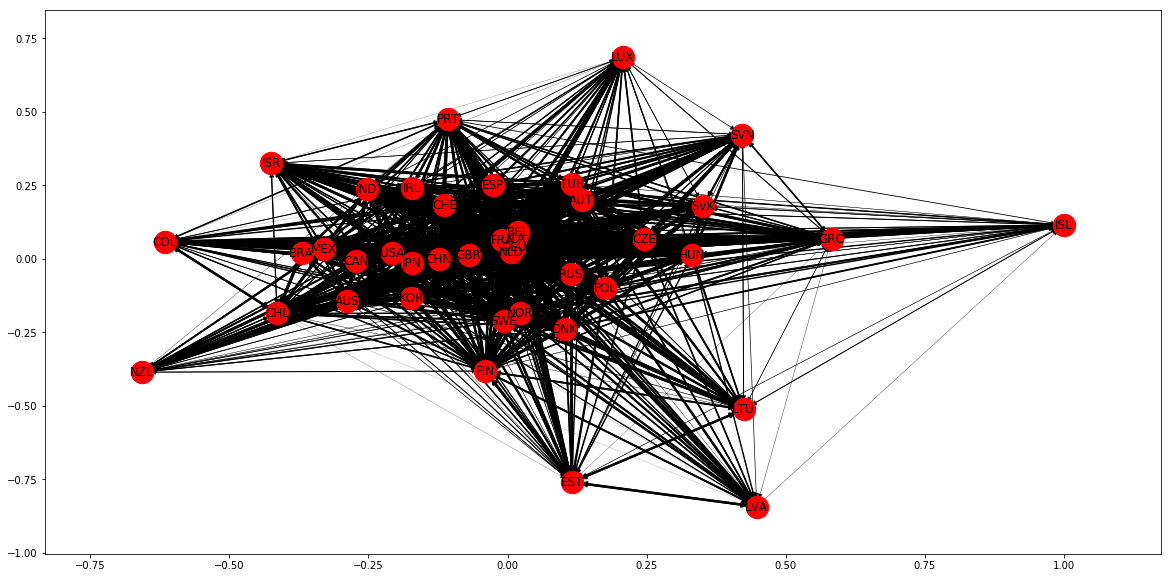

In [6]:
# Draw New data

EDGE_WIDTH_MULTIPLIER = 0.5
plt.figure(figsize=(20,10))

# Layout the graph using a spring model
pos = nx.spring_layout(g_new, iterations=100, weight="weight")

# Draw the nodes on the screen
nx.draw_networkx_nodes(g_new, pos, node_size=500)

# Add labels to the nodes
nx.draw_networkx_labels(g_new, pos)

# Create an array with edge widths
edgewidth = []
for u, v, d in g_new.edges(data=True):
    weight = math.log(d['weight'])*EDGE_WIDTH_MULTIPLIER
    edgewidth.append(weight)

# Use the edgewidth array to draw the edges
_ = nx.draw_networkx_edges(g_new, pos, width=edgewidth, )


# Compute total imports and exports

In [7]:
# Initialize total imports and exports dictionary

sorted_countries = sorted(COUNTRIES)
imp1980 = {k:0 for k in sorted_countries}
exp1980 = {k:0 for k in sorted_countries}
imp2013 = {k:0 for k in sorted_countries}
exp2013 = {k:0 for k in sorted_countries}

for u, v, d in g_old.edges(data=True):
    imp1980[v] += d['weight']
    exp1980[u] += d['weight']
for u, v, d in g_new.edges(data=True):
    imp2013[v] += d['weight']
    exp2013[u] += d['weight']

flowsData = {
    'exp1980': [exp1980[c] for c in sorted_countries],
    'imp1980': [imp1980[c] for c in sorted_countries],
    'exp2013': [exp2013[c] for c in sorted_countries], 
    'imp2013': [imp2013[c] for c in sorted_countries],
}

flowsDF = pd.DataFrame(flowsData, index=sorted_countries)
flowsDF

,exp1980,imp1980,exp2013,imp2013
AUS,1250.863749,1271.005666,16588.411324,13356.295214
AUT,1173.045415,1677.155585,12275.562866,12990.784964
BEL,4329.735082,4876.560751,34346.382050,33875.653489
BRA,1076.219332,873.575168,8071.258777,9518.498166
CAN,4823.462333,4299.236581,36483.462624,34553.572388
CHE,2086.482002,2805.705251,16231.779925,16654.430309
CHL,258.154166,245.547917,5516.017965,5148.651535
CHN,716.573667,1101.041500,100868.661848,49215.120002
COL,294.573250,291.195083,2860.122881,2787.382675
CZE,0.000000,0.000000,12441.634694,11040.796003


# Compute hubs and authorities

In [8]:
def normalize(d):
    dicsum = sum(d.values())
    for k in d.keys():
        d[k] /= dicsum
    return d

In [9]:
def hub_authorities(g, total_exports, total_imports):
    # Initialize hub scores with 1/N
    h = {k:1/len(g) for k in g.nodes()}
    
    for i in range(50):
        a = {k:0 for k in g.nodes()} # Initialize a
        for u, v, d in g.edges(data=True):
            a[v] += h[u] * d['weight'] # Update a
        a = normalize(a) # Normalize a
        h = {k:0 for k in g.nodes()} # Initialize h
        for u, v, d in g.edges(data=True):
            h[u] += a[v] * d['weight']
        h = normalize(h) # Normalize h
    return h, a

In [10]:
h1980, a1980 = hub_authorities(g_old, exp1980, imp1980)
h2013, a2013 = hub_authorities(g_new, exp2013, imp2013)

In [11]:
# Add these columns to your data frame
flowsDF['h1980'] = pd.Series(h1980)
flowsDF['a1980'] = pd.Series(a1980)
flowsDF['h2013'] = pd.Series(h2013)
flowsDF['a2013'] = pd.Series(a2013)

flowsDF

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
AUS,1250.863749,1271.005666,16588.411324,13356.295214,0.013266,0.016601,0.012858,0.022214
AUT,1173.045415,1677.155585,12275.562866,12990.784964,0.014041,0.021712,0.009532,0.013783
BEL,4329.735082,4876.560751,34346.382050,33875.653489,0.057161,0.063071,0.026141,0.028082
BRA,1076.219332,873.575168,8071.258777,9518.498166,0.014280,0.013692,0.013171,0.008886
CAN,4823.462333,4299.236581,36483.462624,34553.572388,0.078229,0.082582,0.126570,0.046515
CHE,2086.482002,2805.705251,16231.779925,16654.430309,0.024880,0.034370,0.017677,0.017388
CHL,258.154166,245.547917,5516.017965,5148.651535,0.003457,0.003874,0.006132,0.008212
CHN,716.573667,1101.041500,100868.661848,49215.120002,0.008416,0.015274,0.196018,0.045361
COL,294.573250,291.195083,2860.122881,2787.382675,0.004095,0.004690,0.008170,0.003081
CZE,0.000000,0.000000,12441.634694,11040.796003,NaN,NaN,0.007473,0.012057


In [12]:
display(flowsDF.sort_values(by='exp1980', ascending=False).head(5))

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
USA,15166.754334,12138.223666,94651.265324,156122.845334,0.151582,0.113136,0.050161,0.310534
DEU,12666.336668,11826.018917,104392.847444,91616.691918,0.122329,0.104502,0.076856,0.068461
FRA,6966.056085,7974.412166,39675.014829,49010.963544,0.078861,0.089345,0.030400,0.048659
GBR,6750.748250,7198.119999,32212.012326,47955.091971,0.070507,0.074569,0.034203,0.046731
JPN,6421.844418,4696.401833,40754.120740,40450.038868,0.079666,0.058226,0.061405,0.075206


In [13]:
print("Top 5 countries for each measure")
print("=" * 110)

for data in flowsDF.columns:
    print(data)
    print(list(flowsDF.sort_values(by=data, ascending=False).head(5).index))
    print(list(flowsDF.sort_values(by=data, ascending=False).head(5)[data].values))
    print("=" * 110)

Top 5 countries for each measure
exp1980
['USA', 'DEU', 'FRA', 'GBR', 'JPN']
[15166.754334000001, 12666.336668000002, 6966.056085, 6750.748250000002, 6421.844418000001]
imp1980
['USA', 'DEU', 'FRA', 'GBR', 'ITA']
[12138.223666, 11826.018917000005, 7974.412165999999, 7198.1199990000005, 5513.569248999999]
exp2013
['DEU', 'CHN', 'USA', 'JPN', 'NLD']
[104392.847444, 100868.66184800002, 94651.26532400002, 40754.12074, 40131.29748799999]
imp2013
['USA', 'DEU', 'CHN', 'FRA', 'GBR']
[156122.84533399998, 91616.691918, 49215.12000200001, 49010.963544000006, 47955.09197100001]
h1980
['USA', 'DEU', 'JPN', 'FRA', 'CAN']
[0.15158233408016994, 0.12232901582270476, 0.0796656492777002, 0.07886083311779213, 0.07822856727788442]
a1980
['USA', 'DEU', 'FRA', 'CAN', 'GBR']
[0.1131363319742665, 0.10450205065700795, 0.08934509986312986, 0.08258249952373846, 0.07456874381535906]
h2013
['CHN', 'CAN', 'MEX', 'DEU', 'JPN']
[0.19601760350461575, 0.12656999390551787, 0.10906056764828727, 0.07685570453084821, 0.061

# Comparison of hub/export, authority/import scores

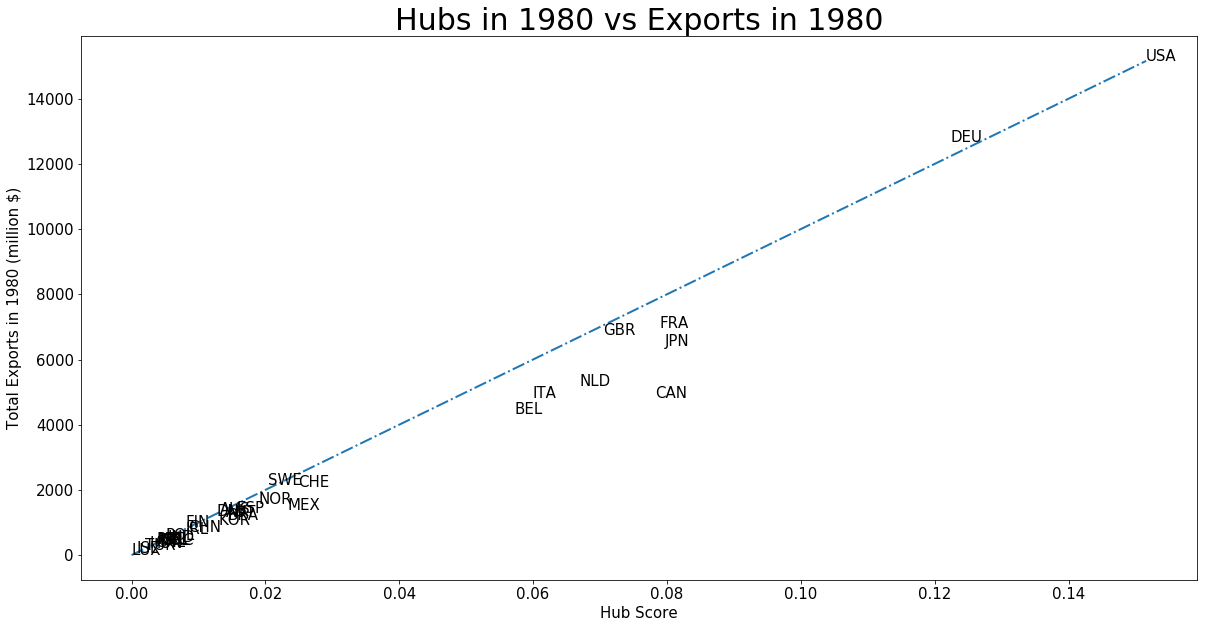

In [14]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot()
plt.title('Hubs in 1980 vs Exports in 1980', fontsize=30)
plt.xlabel('Hub Score', fontsize=15)
plt.ylabel('Total Exports in 1980 (million $)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add a diagonal line
plt.plot([min(h1980.values()),max(h1980.values())], [min(exp1980.values()),max(exp1980.values())], '-.', lw=2)
# Do the scatter plot with texts
for country in set(h1980.keys()).intersection(set(exp1980.keys())):
    plt.text(h1980[country], exp1980[country], country, fontsize=15)

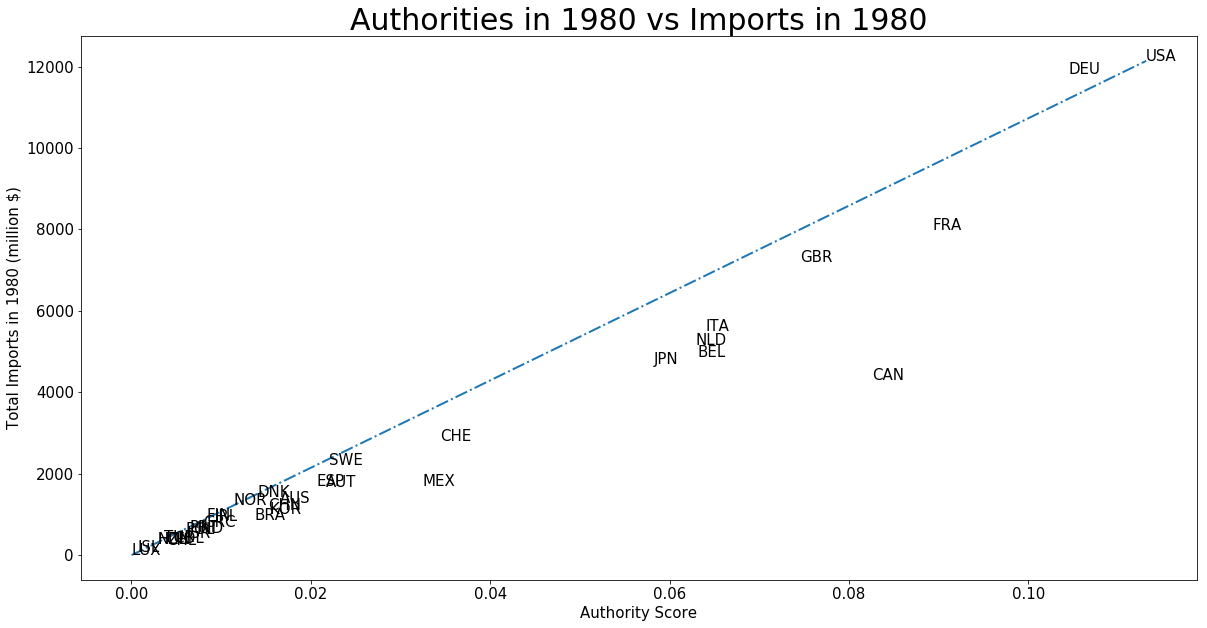

In [15]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot()
plt.title('Authorities in 1980 vs Imports in 1980', fontsize=30)
plt.xlabel('Authority Score', fontsize=15)
plt.ylabel('Total Imports in 1980 (million $)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add a diagonal line
plt.plot([min(a1980.values()),max(a1980.values())], [min(imp1980.values()),max(imp1980.values())], '-.', lw=2)
# Do the scatter plot with texts
for country in set(a1980.keys()).intersection(set(imp1980.keys())):
    plt.text(a1980[country], imp1980[country], country, fontsize=15)

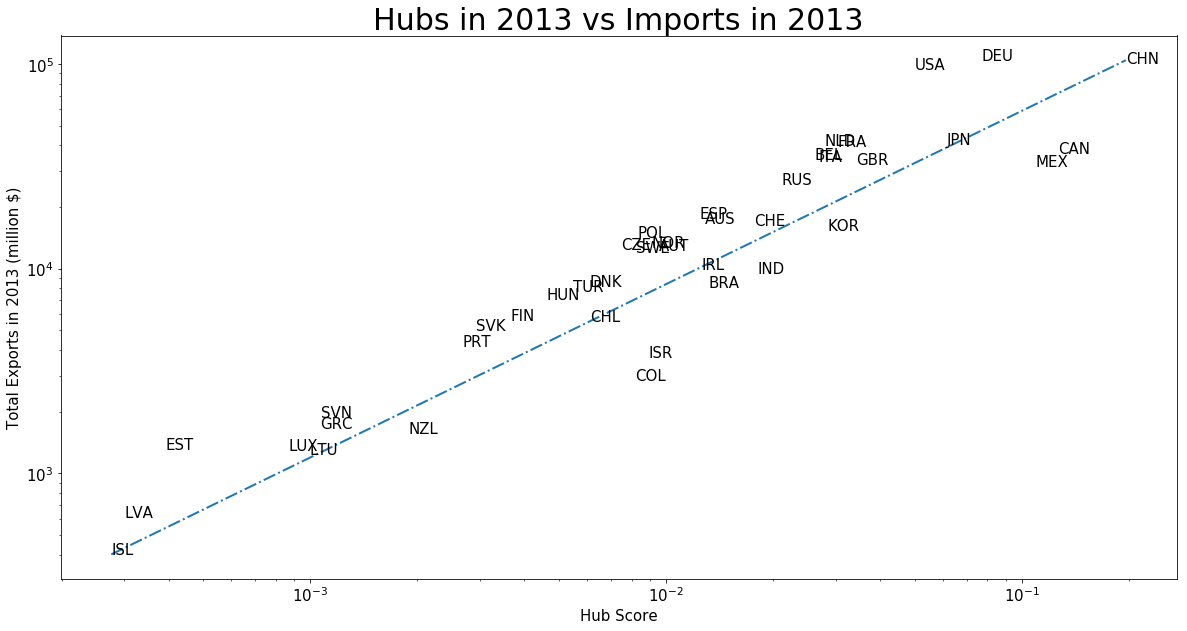

In [16]:
# Create plot
plt.figure(figsize=(20,10))
plt.loglog()
plt.title('Hubs in 2013 vs Imports in 2013', fontsize=30)
plt.xlabel('Hub Score', fontsize=15)
plt.ylabel('Total Exports in 2013 (million $)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add a diagonal line
plt.plot([min(h2013.values()),max(h2013.values())], [min(exp2013.values()),max(exp2013.values())], '-.', lw=2)
# Do the scatter plot with texts
for country in set(h2013.keys()).intersection(set(exp2013.keys())):
    plt.text(h2013[country], exp2013[country], country, fontsize=15)

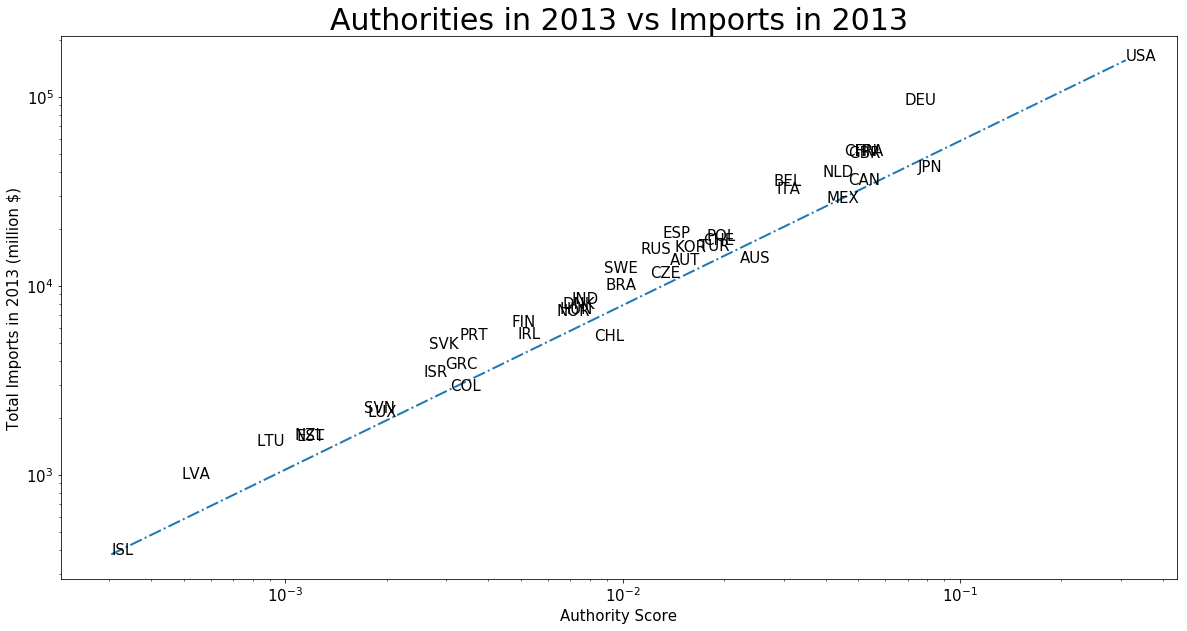

In [17]:
# Create plot
plt.figure(figsize=(20,10))
plt.loglog()
plt.title('Authorities in 2013 vs Imports in 2013', fontsize=30)
plt.xlabel('Authority Score', fontsize=15)
plt.ylabel('Total Imports in 2013 (million $)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add a diagonal line
plt.plot([min(a2013.values()),max(a2013.values())], [min(imp2013.values()),max(imp2013.values())], '-.', lw=2)
# Do the scatter plot with texts
for country in set(a2013.keys()).intersection(set(imp2013.keys())):
    plt.text(a2013[country], imp2013[country], country, fontsize=15)